<a href="https://colab.research.google.com/github/abhiruchi97/Econometrics-in-Python/blob/master/Trend_component__time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Authors: Abhiruchi Rathi & Amit Pawar
## 31st May 2020

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
#!pip install statsmodels --upgrade
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from datetime import datetime

## The objective of this exercise is to extract the trend component of a time-series
#### Example: In macroeconomics, the moving natural rate theory suggests that the unemployment rate is a stationary series around its moving target and its steady state- the natural rate of unemployment. Hence, the trend component of the unemployment series is equal to the natural rate. We will estimate the natural rate using data on monthly unemployment rate, using the following methodologies:


*   Hodrick-Prescott filter
*   Baxter-King filter
*   Christiano-Fitzgerald filter
*   Beveridge-Nelson decomposition






In [106]:
unemp_m = pd.read_csv("unemp_monthly.csv", parse_dates=True, index_col = 'DATE')
unemp_m.dropna(inplace = True)
unemp_m.head()

,UNRATE
DATE,
1960-10-01,6.1
1960-11-01,6.1
1960-12-01,6.6
1961-01-01,6.6
1961-02-01,6.9


### Hodrick-Prescott (HP) filter

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fb866eb70>,
      dtype=object)

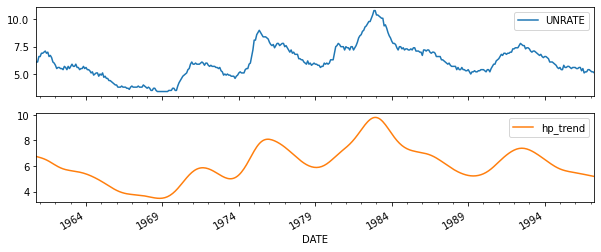

In [107]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(unemp_m['UNRATE'])
#unemp_m['hp_cycle'] = hp_cycle
unemp_m['hp_trend'] = hp_trend

unemp_m.plot(subplots = True, figsize = (10,4))

### Baxter-King approximate band-pass filter

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fb86a66a0>,
      dtype=object)

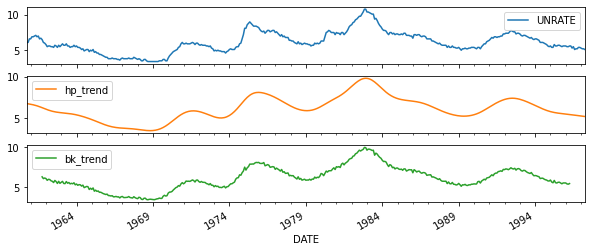

In [108]:
bk_cycles = sm.tsa.filters.bkfilter(unemp_m['UNRATE'])
unemp_m['bk_trend'] = unemp_m['UNRATE'] - pd.Series(bk_cycles)
unemp_m.plot(subplots = True, figsize = (10,4))

## Christiano-Fitzgerald approximate band-pass filter

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fb8368278>,
      dtype=object)

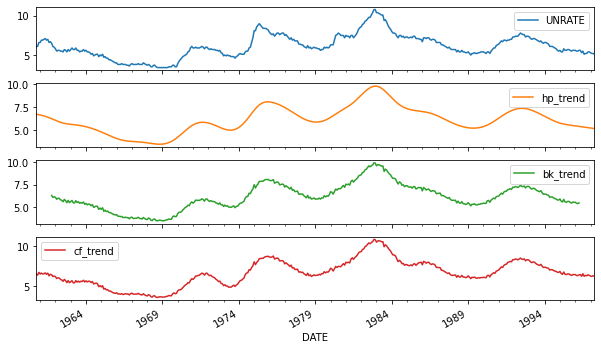

In [109]:
cf_cycles, cf_trend = sm.tsa.filters.cffilter(unemp_m['UNRATE'])
#unemp_m['cf_cycle'] = cf_cycles
unemp_m['cf_trend'] = cf_trend
unemp_m.plot(subplots = True, figsize = (10,6))

### Beveridge-Nelson decomposition

In [110]:
bn_dec = pd.read_csv("unemp_monthly.csv", parse_dates=True, index_col = 'DATE')
bn_dec.head()

,UNRATE
DATE,
1960-10-01,6.1
1960-11-01,6.1
1960-12-01,6.6
1961-01-01,6.6
1961-02-01,6.9


In [111]:
bn_dec["diff"] = bn_dec["UNRATE"] - bn_dec["UNRATE"].shift(1)
bn_dec["diff_mean"] = bn_dec["diff"] - bn_dec['diff'].mean()
bn_dec.dropna(inplace=True)
bn_dec.head()

,UNRATE,diff,diff_mean
DATE,,,
1960-11-01,6.1,0.0,0.002283
1960-12-01,6.6,0.5,0.502283
1961-01-01,6.6,0.0,0.002283
1961-02-01,6.9,0.3,0.302283
1961-03-01,6.9,0.0,0.002283


In [112]:
# Taking 8 lags and auto-selecting the best orders of autoregression on the differenced series of unemployment rate

select = ar_select_order(bn_dec["diff_mean"], 8, trend= 'n', glob=True)
select.ar_lags
res = select.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:              diff_mean   No. Observations:                  438
Model:              Restr. AutoReg(4)   Log Likelihood                 150.425
Method:               Conditional MLE   S.D. of innovations              0.171
Date:                Sun, 31 May 2020   AIC                             -3.513
Time:                        17:14:33   BIC                             -3.475
Sample:                    03-01-1961   HQIC                            -3.498
                         - 04-01-1997                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diff_mean.L2     0.1863      0.046      4.011      0.000       0.095       0.277
diff_mean.L3     0.1675      0.045      3.741      0.000       0.080       0.255
diff_mean.L4     0.1791      0.046      3.88

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [113]:
'''The formula for BN trend component = y_t + (phi/1-phi) * delta(differenced(1)-mean)_t
From the results above, all our 3 selected AR lags have p-values=0; we choose diff_mean.L4 i.e. the 4th lag = 0.1791 = phi and put in the above formula
RHS gives the BN trend = natural rate estimates'''

bn_dec['natural_rate'] = bn_dec['UNRATE'] + (0.1791/(1-0.1791)) * bn_dec['diff_mean']
bn_dec.head()

,UNRATE,diff,diff_mean,natural_rate
DATE,,,,
1960-11-01,6.1,0.0,0.002283,6.100498
1960-12-01,6.6,0.5,0.502283,6.709586
1961-01-01,6.6,0.0,0.002283,6.600498
1961-02-01,6.9,0.3,0.302283,6.965951
1961-03-01,6.9,0.0,0.002283,6.900498


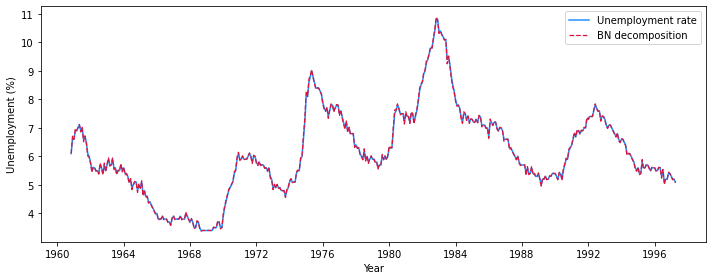

In [114]:
# Plotting the natural rate derived from BN decomposition alongside the actual unemployment rate series

plt.figure(figsize=(10, 4))
plt.plot(bn_dec.index, bn_dec['UNRATE'], label="Unemployment rate", c="dodgerblue", linewidth=1.5)
plt.plot(bn_dec.index, bn_dec['natural_rate'], linestyle = '--', c="crimson", label="BN decomposition", linewidth=1.25)
plt.xlabel("Year")
plt.ylabel("Unemployment (%)")
plt.legend()
plt.tight_layout()

### Plotting all versions of the trend component

In [115]:
unemp_m = pd.concat([unemp_m, bn_dec['natural_rate']], axis=1)
unemp_m.iloc[0,4] = 6.10
unemp_m.head()

,UNRATE,hp_trend,bk_trend,cf_trend,natural_rate
DATE,,,,,
1960-10-01,6.1,6.747674,NaN,6.473327,6.100000
1960-11-01,6.1,6.720293,NaN,6.385468,6.100498
1960-12-01,6.6,6.692507,NaN,6.722284,6.709586
1961-01-01,6.6,6.663523,NaN,6.522501,6.600498
1961-02-01,6.9,6.632492,NaN,6.639227,6.965951


In [0]:
unemp_m.dropna(inplace = True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2fb900c3c8>,
      dtype=object)

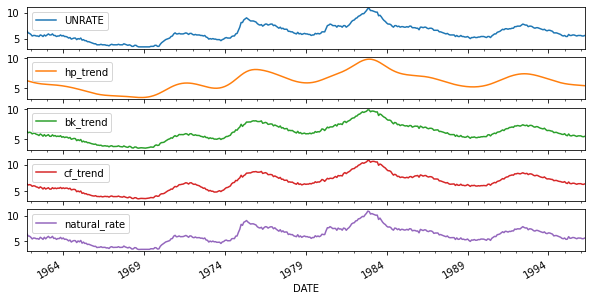

In [117]:
unemp_m.plot(subplots = True, figsize = (10,5))

In [118]:
lst = [i+"_error" for i in unemp_m.columns[1:]]
lst

['hp_trend_error', 'bk_trend_error', 'cf_trend_error', 'natural_rate_error']

In [0]:
unemp_m[lst[0]] = unemp_m['UNRATE'] - unemp_m['hp_trend']
unemp_m[lst[1]] = unemp_m['UNRATE'] - unemp_m['bk_trend']
unemp_m[lst[2]] = unemp_m['UNRATE'] - unemp_m['cf_trend']
unemp_m[lst[3]] = unemp_m['UNRATE'] - unemp_m['natural_rate']

In [120]:
unemp_m.head()

,UNRATE,hp_trend,bk_trend,cf_trend,natural_rate,hp_trend_error,bk_trend_error,cf_trend_error,natural_rate_error
DATE,,,,,,,,,
1961-10-01,6.5,6.249456,6.314951,6.428246,6.456863,0.250544,0.185049,0.071754,0.043137
1961-11-01,6.1,6.187968,6.095408,6.202194,6.013228,-0.087968,0.004592,-0.102194,0.086772
1961-12-01,6.0,6.126504,6.169829,6.271018,5.978681,-0.126504,-0.169829,-0.271018,0.021319
1962-01-01,5.8,6.066286,6.106441,6.195826,5.756863,-0.266286,-0.306441,-0.395826,0.043137
1962-02-01,5.5,6.008458,5.887357,5.955008,5.435046,-0.508458,-0.387357,-0.455008,0.064954


In [121]:
unemp_m[lst] = unemp_m[lst].apply(lambda x: x**2)
unemp_m.head()

,UNRATE,hp_trend,bk_trend,cf_trend,natural_rate,hp_trend_error,bk_trend_error,cf_trend_error,natural_rate_error
DATE,,,,,,,,,
1961-10-01,6.5,6.249456,6.314951,6.428246,6.456863,0.062772,0.034243,0.005149,0.001861
1961-11-01,6.1,6.187968,6.095408,6.202194,6.013228,0.007738,0.000021,0.010444,0.007529
1961-12-01,6.0,6.126504,6.169829,6.271018,5.978681,0.016003,0.028842,0.073451,0.000455
1962-01-01,5.8,6.066286,6.106441,6.195826,5.756863,0.070908,0.093906,0.156678,0.001861
1962-02-01,5.5,6.008458,5.887357,5.955008,5.435046,0.258530,0.150046,0.207033,0.004219


In [127]:
for i in lst:
  k = np.sqrt(unemp_m[i].sum())/len(unemp_m)
  print('RMSE for {} is {}'.format(i,k))

RMSE for hp_trend_error is 0.014041228833606955
RMSE for bk_trend_error is 0.013034547182042819
RMSE for cf_trend_error is 0.030583030254028563
RMSE for natural_rate_error is 0.0019633594614106866


In conclusion, the Root Mean Squared Error (RMSE) i.e. the standard deviation of residuals is lowest for BN decomposition as compared to the other filters used for deriving trend components. However, this does not imply that the BN trend is the best representation of the natural rate, since we do not actually observe the natural rate.